# Project 2 - Continuous Control

The follow project works with the Reacher Environment. The gaol is to train an agent to move an double jointed arm to target locations. A reward of +0.1 is provided every time agent reaches the hand in target location.

The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector should be a number between -1 and 1.

I have trained my model using the version 1, that consists of single agent and is an episodic task.

In [1]:
from unityagents import UnityEnvironment
from train_single import Agent
import torch
import numpy as np
from collections import deque
from matplotlib import pyplot as plt

I have trained the model by running the train_single.py file from the command line since with Jupyter Notebook it tends to loose connection constantly if I don't keep it active everyonce in a while. So to make it easier for me I decided to train it locally from command line. Therefore I kept track of the scores in `.npz` file and I will show how the scores changed below.

In [2]:
scores = list(np.load("scores.npz")["scores"])
scores_window = deque(maxlen=100)
i_ep = 1
for each in scores:
    scores_window.append(each)
    print('\rEpisode {} \tAverage Score: {:.2f}, Max score: {}, Min score: {}'.format(i_ep, np.mean(scores_window), np.max(scores_window), np.min(scores_window)), end="")
    if i_ep % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_ep, np.mean(scores_window)))
    i_ep += 1

Episode 100	Average Score: 1.93
Episode 200	Average Score: 8.93
Episode 300	Average Score: 16.00


Episode 400	Average Score: 20.26
Episode 500	Average Score: 26.12
Episode 600	Average Score: 28.80
Episode 695 	Average Score: 30.02, Max score: 35.36999920941889, Min score: 23.249999480322003

# Scores plot

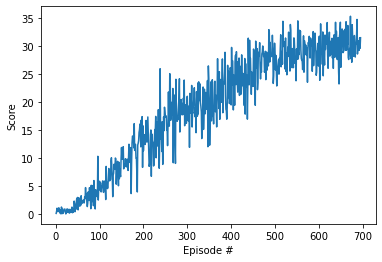

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Performance

In [4]:
env = UnityEnvironment(file_name='Reacher/Reacher.exe') 
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name] # set False if you wish to visualize the environment
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Random performance

In [5]:
agent = Agent(state_size, action_size, 0)
score = 0
for t in range(1000):
    action = agent.act(env_info.vector_observations)
    env_info = env.step(action)[brain_name]
    score += np.mean(env_info.rewards)
print("Final score:", score)

Final score: 0.909999979659915


### Trained Agent's Performance

In [6]:
agent = Agent(state_size, action_size, 0)
agent.network.actor.load_state_dict(torch.load("ddpg_actor_solution.pth"))
env_info = env.reset(train_mode=False)[brain_name]
score = 0
for t in range(1000):
    action = agent.act(env_info.vector_observations)
    env_info = env.step(action)[brain_name]
    score += np.mean(env_info.rewards)
print("Final score:", score)

Final score: 32.51999927312136


# Hyperparameters, Learning Algorithm and Network Architecture

### Hyperparameters

```
BUFFER_SIZE = int(1e6)    # Memory size, the last number of steps it stores
BATCH_SIZE = 64           # Batch size used to train the model 
ACTOR_LR = 1e-4           # Learning rate for the Actor model
CRITIC_LR = 1e-4          # Learning rate for the Critic model
WEIGHT_DECAY = 0          # Weight decay (used for Critic)
TAU = 1e-3                # TAU used to determine how much of local impacts the target
GAMMA = 0.99              # Discount rate
UPDATE_EVERY = 20         # Learn every few steps 
TIMES_UPDATE = 10         # Number of time to learn
```

I have used a relatively large buffer size for it to remember many time step. However for batch size I have a used small 64. It seemed the most stable in learning. A larger batch size was more unstable and was harder to determine whether the agent is learning or not, but with 64 as batch size it was clear to see the agent was learning, so I decided to use that.

For learning rate, in both case I used 1e-4 after some trial and error this seemd the best and stable value. I tried weight decay at first, but eventually I set it to 0, as it seemed stable enough without it.

For TAU and GAMMA I kept it same as the ones I saw in the paper for DDPG, and UPDATE EVERY and Times Update I also kept is same as it was mentioned in the project benchmark. I did try changing it, but eventually this seemed the most ideal.

Some parameters not mentioned above are the ones related to the parameters for adding noise.
```
 mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000
```
I brought the class for noise from another souce, which I have referred in the source code, and I kept the original values. It seemed to work fine so I didn't really change it.

### Network Architecture

So as DDPG is an Actor Critic model, I have two neural networks. Both make use of fully connected layers. Each consist of 2 hidden layer, the first giving 256 second is 128 and then the output size. For the critic layer, the action values are added on the second layer after the input layer.

One thing that really helped in my learning was using leaky relu. Not sure why but in my case when I was just using ReLu my model was very slow in learning, like the average score wouldn't change at all for 300-400 episodes. However when I tried leaky relu it seemd to have a significant improvment.

### Learning Algorithm

I used the learning algorithm specified in the paper. First I updated the critic of the model. There was a target network
that would take the next states and actions to determine the target value for current states using:
`Q_target = rewards + (gamma * Q_targets_next * (1-dones)`
Then using the critic network the predicted values are gathered
`Q_predicted = network.critic(states, actions)`
Then using MSE the loss is determined for the critic to backpropage the critic network's parameters. One more thing that i kept in my code from the benchmark guideline was to clip the gradients for critic model.

To update the actor model, it used the local critic networks negative value as loss. From the sampled experience it would take the states and actions taken by agent to determine the Q value of those. The loss would be averaged and negative value of it. So the actor model would learn to determine actions that would maximize the Q value. Averaging allows it to be more stable in learning.

During training, it was set so that for each episode it would iterate over for 1000 timesteps, and it will continue on the episodes until the average score of 30+ is achieved.

# Problems and Improvement

Above when you visualize the environment with trained agent you will notice it is not always able to go to the target location. So I think the model has high bias and could use more training. I did stop the training just after it achieved the average target score, so definitely training it for a little longer could have improved it a bit more.

I wanted to train the model using version 2 with multiple agents, I think it would give a much better policy. Especially it might be a good idea to implement D4PG or TRPO or TNPG as these models are likely to give a better performing agent. 
DDPG in my case was very unstable, and I had to do a lot of trial and error to come up with policy. That is why I was really happy the moment it achieved the targetted average score. 

Right now if I try the model on version 2, the average score over all agents appear lightly lower than the score of version 1 in most runs. Training with version 2 would have exposed the model to a lot more states, so a bit more of exploration. I also didn't really play with the values of noise, so maybe if I altered that and tried to make the model explore a little more than it could have been a little less underfitted.

I was also wondering it might be better if we used a common network for determining features that got fed into the actor and critic network. This might have made a good model for determining features and would have made it collect more useful information to take better actions.